**Goal**: fetch album data from Spotify for the current dataset with songs. Merge the fetched results with previously fetched album data from LastFm to construct the final "merged_album" column with the corresponding album name for each song.


**New/modified output files**:
- (new)```spotify_data_v1.csv```:
    - track info fetched by 'artist-title' search query from Spotify
    - ['title', 'artist', 'spotify_artist', 'track_id', 'artist_id', 'duration_ms', 'track_popularity', 'album_id', 'album_name', 'album_release_date', 'total_tracks']
- (new)```spotify_artists_v1```:
    - album info fetched by 'artist_id' search query from Spotify
    - ['artist_id', 'artist_name', 'genres', 'followers', 'popularity']
- (new)```merged_albums_songs_v1.csv```:
    - results of the merging process of Spotify and LastFm album data
    - ['title', 'artist', 'merged_album']

# Spotify fetching funcs

In [ ]:
import requests
import json 
from loguru import logger
import pandas as pd
from time import sleep, perf_counter
import subprocess
import random
import os

from src.spotify_fetcher import send_request, get_access_token

In [39]:
def get_track_info(track_name, artist_name, access_token=None):
    if access_token is None:
        access_token = get_access_token()
    
    url = 'https://api.spotify.com/v1/search'

    params = {
        'q': f'track:{track_name} artist:{artist_name}',
        'type': 'track',  # Searching for tracks
        'limit': 1 ,       # Limit to 1 result for simplicity
        'access_token': access_token
    }

    response_json = send_request(url, params=params)
    if response_json is None:
        return
    
    tracks = response_json['tracks']['items']
    if len(tracks) == 0:
        return None
    
    album = tracks[0]['album']

    return {
        'track_name': tracks[0]['name'],
        'artist_name': tracks[0]['artists'][0]['name'],
        'track_id': tracks[0]['id'], 
        'artist_id': tracks[0]['artists'][0]['id'],
        'duration_ms': tracks[0]['duration_ms'], 
        'track_popularity': tracks[0]['popularity'],
        'album_id': album['id'], 
        'album_name': album['name'],
        'album_release_date': album['release_date'],
        'total_tracks': album['total_tracks']
        }

In [40]:
get_track_info('Ван Гог', 'Tember Blanche')

{'track_name': 'Ван Гог',
 'artist_name': 'Tember Blanche',
 'track_id': '6D8qCYvJb47ltDGEKAYSO0',
 'artist_id': '4IGHF22vbC33ColRBUHIXd',
 'duration_ms': 156904,
 'track_popularity': 19,
 'album_id': '0rcz0rPQfLZSv8ww4Jbcql',
 'album_name': 'Ти лиш людина',
 'album_release_date': '2023-04-07',
 'total_tracks': 9}

In [36]:
def get_artist_info(artist_id, access_token=None):
    if access_token is None:
        access_token = get_access_token()
        
    url = f'https://api.spotify.com/v1/artists/{artist_id}'
    params = {
        'access_token': access_token
    }

    response_json = send_request(url, params=params)
    if response_json is None:
        return None

    return {
        'artist_id': response_json['id'],
        'artist_name': response_json['name'],
        'genres': response_json['genres'],
        'followers': response_json['followers']['total'],
        'popularity': response_json['popularity']
    }

In [38]:
get_artist_info('4IGHF22vbC33ColRBUHIXd')

{'artist_id': '4IGHF22vbC33ColRBUHIXd',
 'artist_name': 'Tember Blanche',
 'genres': [],
 'followers': 39947,
 'popularity': 42}

# Fetching data for the whole dataset

Now let's fetch album data for all songs:

In [ ]:
songs_df = pd.read_csv(os.path.join("data", "merged_songs_v1.csv"))

print(songs_df.columns)
print("Total number of songs:", len(songs_df))

Index(['title', 'artist', 'title_listeners', 'title_scrobbles', 'title_tags',
       'genre_tags', 'title_duration', 'audio_path', 'yt_title', 'yt_url',
       'yt_duration', 'yt_views'],
      dtype='object')
Total number of songs: 3166


In [51]:
spotify_csv_path = os.path.join("data", "spotify_data_v1.csv")

if os.path.exists(spotify_csv_path):
    print("Loading existing Spotify data...")
    spotify_df = pd.read_csv(spotify_csv_path)
else:
    # Create an empty DataFrame with the desired columns
    spotify_df = pd.DataFrame(columns=['title', 'artist', 'track_id', 'artist_id', 'duration_ms', 'track_popularity', 'album_id', 'album_name', 'album_release_date', 'total_tracks'])

In [ ]:
access_token = get_access_token()

for i, row in songs_df.iterrows():
    title, artist = row['title'], row['artist']
    track_info = get_track_info(title, artist, access_token)

    if track_info is None:
        logger.error(f"Failed to get track info for {title} by {artist}")
    else:
        # Extract and append track information to the DataFrame in a single step
        spotify_df.loc[i] = [
            title, artist,
            track_info['track_id'], track_info['artist_id'],
            track_info['duration_ms'], track_info['track_popularity'],
            track_info['album_id'], track_info['album_name'],
            track_info['album_release_date'], track_info['total_tracks']
        ]
    
    if i % 100 == 0:
        logger.info(f"Processed {i} songs")
        spotify_df.to_csv(spotify_csv_path, index=False)
        sleep(random.uniform(0.1, 0.5))

spotify_df.to_csv(spotify_csv_path, index=False)


2025-03-31 20:21:18.965 | INFO     | __main__:<module>:20 - Processed 0 songs
2025-03-31 20:21:30.538 | ERROR    | __main__:<module>:8 - Failed to get track info for Квiтка by Океан Ельзи
2025-03-31 20:21:34.671 | ERROR    | __main__:<module>:8 - Failed to get track info for Така, як ти by Океан Ельзи
2025-03-31 20:21:52.783 | ERROR    | __main__:<module>:8 - Failed to get track info for SHUM - Instrumental Version by Go_A
2025-03-31 20:21:53.071 | ERROR    | __main__:<module>:8 - Failed to get track info for Соловей by Go_A
2025-03-31 20:21:55.221 | ERROR    | __main__:<module>:8 - Failed to get track info for Щедрий вечір by Go_A
2025-03-31 20:22:00.712 | ERROR    | __main__:<module>:8 - Failed to get track info for Квіти в волоссі by Бумбокс
2025-03-31 20:22:00.995 | ERROR    | __main__:<module>:8 - Failed to get track info for Eva by Бумбокс
2025-03-31 20:22:04.438 | ERROR    | __main__:<module>:8 - Failed to get track info for Гайки з ямайки by Бумбокс
2025-03-31 20:22:05.661 | ER

# Analysis of the fetched data

In [10]:
import pandas as pd

spotify_csv_path = os.path.join("data", "spotify_data_v1.csv")
spotify_df = pd.read_csv(spotify_csv_path)

spotify_df

,title,artist,track_id,artist_id,duration_ms,track_popularity,album_id,album_name,album_release_date,total_tracks
0,Без бою,Океан Ельзи,0Y5i43d7YtHWyYulOojDXP,6NTzEgUmN1PIBIYEHhf1kS,259896,52,53GqKgF0wipcbZsacXJTMR,Gloria,2005,12
1,Обійми,Океан Ельзи,5561HkcMU0A4i3D6Tlsxhe,6NTzEgUmN1PIBIYEHhf1kS,224111,51,0KS4481ykVKBbjIsxlvyyN,Земля,2013-05-15,12
2,Не питай,Океан Ельзи,3CQHvXdYWhyhCZ0YnOrH3g,6NTzEgUmN1PIBIYEHhf1kS,157376,40,53GqKgF0wipcbZsacXJTMR,Gloria,2005,12
3,Коли тебе нема,Океан Ельзи,2mgX6BJB1HLOUz4RIUJyW3,6NTzEgUmN1PIBIYEHhf1kS,197870,44,6G88Fi3Xa2MGwUTjuS23oh,Янанебібув,2000-02-21,11
4,911,Океан Ельзи,1oD1YaA7KktOlqgPfFjopL,6NTzEgUmN1PIBIYEHhf1kS,209030,44,6lslJRTbrZBqVaBG0L0SFC,Модель,2001-04-20,11
...,...,...,...,...,...,...,...,...,...,...
2404,Ми починаємо,Антитіла,0LNCejQjE2hDJaoG30bbfg,5sc9td6C7xxPa3mOmmvXPu,211408,13,1MTIwCAVeJoCGAjzHn3QX3,Hello,2019-12-18,10
2405,MLNL,Антитіла,1BOUxg5bLrY5b5Y1qPdc54,5sc9td6C7xxPa3mOmmvXPu,201447,19,2phBeilwnMufUlY62nChzn,MLNL,2022-02-25,10
2406,Топити за своє,Антитіла,1QOEAUt6VhA5KnaeKt9ttr,5sc9td6C7xxPa3mOmmvXPu,272368,20,2phBeilwnMufUlY62nChzn,MLNL,2022-02-25,10
2407,Шанхай,Антитіла,1A6T8COiPhgOYUnJlBDFJV,5sc9td6C7xxPa3mOmmvXPu,217901,2,60IhWi6YoJwQadsYMo1ID1,Шанхай,2014-12-03,1


In [13]:
print("Tracks with successful album info retrieval:", len(spotify_df))
print("Unique albums:", len(spotify_df['album_id'].unique()))
print("Unique albums with at least 2 songs:", len(spotify_df[spotify_df['total_tracks'] > 1]['album_id'].unique()))

Tracks with successful album info retrieval: 2409
Unique albums: 732
Unique albums with at least 2 songs: 339


## Albums distribution per artist

Let's explore the album distribution for each artist more closely:

In [ ]:
valid_albums_num = 0

for artist, group in spotify_df.groupby('artist'):
    print(f"Artist: {artist}")
    for album_name in group['album_name'].unique():
        num_songs = len(group[group['album_name'] == album_name])
        if num_songs > 1:
            print(f"        {album_name} - {num_songs}")
            valid_albums_num += 1
    print()

Artist: Artem Pivovarov
        THE BEST - 5
        The Best (UA) - 11
        Твої Вірші, Мої Ноти PT.1 - 9
        Твої Вірші, Мої Ноти PT.2 - 9
        Стихия воды - 8
        Океан - 10
        Земной - 7
        Стихия огня - 6

Artist: BLOOMS CORDA
        Fog Lavender - 8
        Monodance - 10
        Найдорожчі речі у світі - 9
        Gigotosia - 4
        Дощ іде, але сонце світить - 11
        Sottoportico - 4
        7 Pisen - 7
        Monodance Bonus Tracks - EP - 2

Artist: Dazzle Dreams
        Pesni Vysshei Proby - 3
        Dazzle Dreams - 11
        (Go! Go! Go!) Disco Killers - 7
        Diva - 11

Artist: Go_A
        #Ідиназвук - 10
        Рано-раненько - 2
        Krip - 2
        Appesi - 3

Artist: KALUSH
        HOTIN - 11
        Для душі - 3
        ЙО-ЙО (feat. Skofka) - 3

Artist: Kalush Orchestra

Artist: Kazka
        СВЯТА (The Best Of Kazka) - 5
        NIRVANA - 10
        SVIT - 6
        Поруч (Remixes) - 2

Artist: Khrystyna Soloviy
        Жива

In [ ]:
print("Number of albums with at least 2 songs:", valid_albums_num)

Number of albums with at least 2 songs: 273


## artist_id (Spotify) vs artist (LastFM)

Let's explore why do we have more artist_ids than artist names:

In [21]:
print("Unique artists (by spotify artist_id):", len(spotify_df['artist_id'].unique()))
print("Unique artists (by artist name):", len(spotify_df['artist'].unique()))

Unique artists (by spotify artist_id): 78
Unique artists (by artist name): 57


In [19]:
artists_with_multiple_ids = spotify_df.groupby('artist')['artist_id'].nunique()
artists_with_multiple_ids = artists_with_multiple_ids[artists_with_multiple_ids > 1]

print("Artists with more than one unique artist_id assigned:")
for artist in artists_with_multiple_ids.index:
    print(f"{artist}: {artists_with_multiple_ids[artist]} unique artist_ids")

Artists with more than one unique artist_id assigned:
Go_A: 6 unique artist_ids
KALUSH: 2 unique artist_ids
Kalush Orchestra: 2 unique artist_ids
Kazka: 2 unique artist_ids
Khrystyna Soloviy: 2 unique artist_ids
Klavdia Petrivna: 2 unique artist_ids
Lama: 3 unique artist_ids
PROBASS ∆ HARDI: 2 unique artist_ids
Sad Novelist: 3 unique artist_ids
The Hardkiss: 2 unique artist_ids
dity inzheneriv: 2 unique artist_ids
renie cares: 2 unique artist_ids
Брати Гадюкіни: 3 unique artist_ids
Гурт [О]: 2 unique artist_ids
Марія Бурмака: 2 unique artist_ids
Ницо Потворно: 3 unique artist_ids
Олександр Пономарьов: 2 unique artist_ids
СТРУКТУРА ЩАСТЯ: 4 unique artist_ids
Тарас Чубай: 2 unique artist_ids


In [20]:
for artist in artists_with_multiple_ids.index:
    artist_ids = spotify_df[spotify_df['artist'] == artist]['artist_id'].unique()
    print(f"Artist: {artist}")
    print(f"Unique artist_ids: {artist_ids}")
    
    alternative_names = []
    for artist_id in artist_ids:
        artist_info = get_artist_info(artist_id)
        if artist_info and artist_info['artist_name'] not in alternative_names:
            alternative_names.append(artist_info['artist_name'])
    
    print(f"Alternative artist names fetched: {alternative_names}")
    print()

Artist: Go_A
Unique artist_ids: ['4kvCU3MzggM2piZCqvxj0x' '0gy5CrSPrOW5DjAFOgI8rM'
 '5ctFffJBdJe8PZL7W7NeML' '0OzxPXyowUEQ532c9AmHUR'
 '2NwhydIhX4Bv42ClHfZ3dM' '4lOvHSxWj02P2JpJ7AWdpU']
Alternative artist names fetched: ['Go_A', 'Go-A', 'Fleshgod Apocalypse', 'Giacomo Puccini', 'Anna Gold']

Artist: KALUSH
Unique artist_ids: ['46rVVJwHWNS7C7MaWXd842' '7tKGQNu7rnSSZKFX0Zeq76']
Alternative artist names fetched: ['KALUSH']

Artist: Kalush Orchestra
Unique artist_ids: ['6fNkvAT7XRYuIynD5RTSLf' '46rVVJwHWNS7C7MaWXd842']
Alternative artist names fetched: ['Kalush Orchestra', 'KALUSH']

Artist: Kazka
Unique artist_ids: ['6tnqzaOroG2OtBaSfVJbEw' '2N0mbAIb33TV4rvt4TOXe4']
Alternative artist names fetched: ['KAZKA', 'ROXOLANA']

Artist: Khrystyna Soloviy
Unique artist_ids: ['5lLVx3mMyUvZ9QKzM09CZa' '2Reqc0B9PCsI6t78c9k11o']
Alternative artist names fetched: ['Khrystyna Soloviy', 'Zhadan i Sobaky']

Artist: Klavdia Petrivna
Unique artist_ids: ['5BwbVAdT6rFF2vGVE8su2y' '58UBmhZzNl22EI94dh9Gx0']
Al

As we can see, there are some mismatches in the found song-artist pairs. That leads to the assumption that there may be some errors in the fetched album data. 

Thus, let's fetch artist names and add this data to the previosly fetch dataframe to enable further filtering based on artist names similarity:

(note: interesting example with Lama, who has 3 differnt artist_ids and the same artist_name, which means that the string similarity filtering is not enough for 100% accuracy)

In [25]:
spotify_artist_df_path = os.path.join("data", "spotify_artists_v1.csv")

if os.path.exists(spotify_artist_df_path):
    spotify_artist_df = pd.read_csv(spotify_artist_df_path)
else:
    spotify_artist_df = pd.DataFrame(columns=['artist_id', 'artist_name', 'genres', 'followers', 'popularity'])

In [29]:
from loguru import logger

for i, row in spotify_df.iterrows():
    artist_id = row['artist_id']

    if artist_id not in spotify_artist_df['artist_id'].values:
        artist_info = get_artist_info(artist_id)
        
        if artist_info is not None:
            spotify_artist_df.loc[len(spotify_artist_df)] = [
                artist_info['artist_id'],
                artist_info['artist_name'],
                ', '.join(artist_info['genres']) if isinstance(artist_info['genres'], list) else artist_info['genres'],
                artist_info['followers'],
                artist_info['popularity']
            ]
        else:
            logger.warn(f"Failed to get artist info for {artist_id}")
    else:
        artist_info = spotify_artist_df[spotify_artist_df['artist_id'] == artist_id].iloc[0]

    # also add the artist name column to the spotify_df
    if artist_info is not None:
        spotify_df.at[i, 'spotify_artist'] = artist_info['artist_name']
        
    if i % 100 == 0:
        logger.info(f"Processed {i} artists")
        spotify_artist_df.to_csv(spotify_artist_df_path, index=False)
        spotify_df.to_csv(spotify_csv_path, index=False)

spotify_artist_df.to_csv(spotify_artist_df_path, index=False)   
spotify_df.to_csv(spotify_csv_path, index=False)
    

2025-04-02 16:18:25.257 | INFO     | __main__:<module>:27 - Processed 0 artists
2025-04-02 16:18:28.266 | INFO     | __main__:<module>:27 - Processed 100 artists
2025-04-02 16:18:29.461 | INFO     | __main__:<module>:27 - Processed 200 artists
2025-04-02 16:18:30.005 | INFO     | __main__:<module>:27 - Processed 300 artists
2025-04-02 16:18:31.308 | INFO     | __main__:<module>:27 - Processed 400 artists
2025-04-02 16:18:31.921 | INFO     | __main__:<module>:27 - Processed 500 artists
2025-04-02 16:18:33.819 | INFO     | __main__:<module>:27 - Processed 600 artists
2025-04-02 16:18:35.232 | INFO     | __main__:<module>:27 - Processed 700 artists
2025-04-02 16:18:37.687 | INFO     | __main__:<module>:27 - Processed 800 artists
2025-04-02 16:18:39.798 | INFO     | __main__:<module>:27 - Processed 900 artists
2025-04-02 16:18:43.680 | INFO     | __main__:<module>:27 - Processed 1000 artists
2025-04-02 16:18:45.096 | INFO     | __main__:<module>:27 - Processed 1100 artists
2025-04-02 16:18

In [34]:
spotify_df = spotify_df[['title', 'artist', 'spotify_artist', 'track_id', 'artist_id', 'duration_ms', 'track_popularity', 'album_id', 'album_name', 'album_release_date', 'total_tracks']]
spotify_df.to_csv(spotify_csv_path, index=False)

# Concat Spotify and Last.Fm album data

## Matching albums

Compare the spotify data about albums with the LastFm data:

In [41]:
albums_lastfm_df = pd.read_csv(os.path.join("data", "albums_filtered_v1.csv"))
albums_lastfm_df

,artist,album,num_tracks,album_length,release_date,listeners,scrobbles,tags,tracks
0,BLOOMS CORDA,7 Pisen,7.0,27:03,23 April 2014,285,"2,627","['ukrainian', 'funk', 'lounge', 'ukraine', 'po...","['zemletrus', 'viter', 'scho take bez-tebe-vec..."
1,BLOOMS CORDA,Fog Lavender,8.0,30:46,28 October 2018,"3,837","34,793","['ukr', 'ukrainian', 'funk', 'lounge', 'ukrain...","['Kolo', 'Mozhe', 'Plateau', 'Moya california'..."
2,BLOOMS CORDA,Fog Lavender [Explicit],8.0,NaN,31 March 2020,20,37,"['ukrainian', 'funk', 'lounge', 'ukraine', 'po...","['Kolo', 'Mozhe', 'Plateau', 'Moya california'..."
3,BLOOMS CORDA,Gigotosia,10.0,41:44,19 October 2016,"1,381","17,234","['ukrainian', 'funk', 'lounge', 'ukraine', 'po...","['kudy vse pishlo', 'run', 'Tvoi glaza', 'Tetr..."
4,BLOOMS CORDA,Monodance,10.0,44:24,19 October 2015,"2,594","20,632","['ukrainian', 'funk', 'lounge', 'ukraine', 'po...","['epigraph', 'lyst do Kathrine', 'Dlya Polnogo..."
...,...,...,...,...,...,...,...,...,...
373,Фактично Самі,Б.П.П. (Болєзні Пєвчіх Птіц),16.0,77:25,2001,115,"2,062","['alternative', 'rock', 'ukraina', 'ukrainian'...","['Танці мене', 'Недоля', 'Хоп', 'Фарба', 'Між ..."
374,Фактично Самі,Космічний Вакуум,22.0,76:53,2007,438,"8,606","['ukrainian', 'alternative', 'female vocalists...","['Палеовізит', 'Орай', 'Не страшно під космічн..."
375,Холодне Сонце,Промені сліз,12.0,NaN,2004,"2,535","81,402","['love metal', 'ukraine', 'ukrainian', 'ukrain...","['Темна троянда (Intro)', 'Тiнь кохання', 'Str..."
376,Холодне Сонце,Театр темних пелюсток,15.0,NaN,7 February 2018,"2,057","108,233","['love metal', 'ukrainian', 'gothic metal', 'u...","['Enter The Theatre', 'Попіл', 'У чужому теплі..."


In [55]:
spotify_df = pd.read_csv(os.path.join("data", "spotify_data_v1.csv"))
spotify_df

,title,artist,spotify_artist,track_id,artist_id,duration_ms,track_popularity,album_id,album_name,album_release_date,total_tracks
0,Без бою,Океан Ельзи,Okean Elzy,0Y5i43d7YtHWyYulOojDXP,6NTzEgUmN1PIBIYEHhf1kS,259896,52,53GqKgF0wipcbZsacXJTMR,Gloria,2005,12
1,Обійми,Океан Ельзи,Okean Elzy,5561HkcMU0A4i3D6Tlsxhe,6NTzEgUmN1PIBIYEHhf1kS,224111,51,0KS4481ykVKBbjIsxlvyyN,Земля,2013-05-15,12
2,Не питай,Океан Ельзи,Okean Elzy,3CQHvXdYWhyhCZ0YnOrH3g,6NTzEgUmN1PIBIYEHhf1kS,157376,40,53GqKgF0wipcbZsacXJTMR,Gloria,2005,12
3,Коли тебе нема,Океан Ельзи,Okean Elzy,2mgX6BJB1HLOUz4RIUJyW3,6NTzEgUmN1PIBIYEHhf1kS,197870,44,6G88Fi3Xa2MGwUTjuS23oh,Янанебібув,2000-02-21,11
4,911,Океан Ельзи,Okean Elzy,1oD1YaA7KktOlqgPfFjopL,6NTzEgUmN1PIBIYEHhf1kS,209030,44,6lslJRTbrZBqVaBG0L0SFC,Модель,2001-04-20,11
...,...,...,...,...,...,...,...,...,...,...,...
2404,Ми починаємо,Антитіла,Antytila,0LNCejQjE2hDJaoG30bbfg,5sc9td6C7xxPa3mOmmvXPu,211408,13,1MTIwCAVeJoCGAjzHn3QX3,Hello,2019-12-18,10
2405,MLNL,Антитіла,Antytila,1BOUxg5bLrY5b5Y1qPdc54,5sc9td6C7xxPa3mOmmvXPu,201447,19,2phBeilwnMufUlY62nChzn,MLNL,2022-02-25,10
2406,Топити за своє,Антитіла,Antytila,1QOEAUt6VhA5KnaeKt9ttr,5sc9td6C7xxPa3mOmmvXPu,272368,20,2phBeilwnMufUlY62nChzn,MLNL,2022-02-25,10
2407,Шанхай,Антитіла,Antytila,1A6T8COiPhgOYUnJlBDFJV,5sc9td6C7xxPa3mOmmvXPu,217901,2,60IhWi6YoJwQadsYMo1ID1,Шанхай,2014-12-03,1


In [42]:
matching_albums = pd.merge(
    spotify_df[['album_name', 'artist']].drop_duplicates(),
    albums_lastfm_df[['album', 'artist']].rename(columns={'album': 'album_name'}),
    on=['album_name', 'artist']
)

print("Number of matching albums:", len(matching_albums))
matching_albums

Number of matching albums: 178


,album_name,artist
0,Gloria,Океан Ельзи
1,Земля,Океан Ельзи
2,Янанебібув,Океан Ельзи
3,Модель,Океан Ельзи
4,Суперсиметрія,Океан Ельзи
...,...,...
173,Hello,Антитіла
174,Сонце,Антитіла
175,Над полюсами,Антитіла
176,Все красиво,Антитіла


## Merging datasets

In [43]:
lastfm_df = pd.read_csv(os.path.join("data", "albums_songs_v1.csv"))
lastfm_df.loc[lastfm_df['main_album'] == 'Other', 'main_album'] = None
lastfm_df

,title,artist,albums,albums_filtered,main_album
0,Без бою,Океан Ельзи,"['1221', 'Gloria']","['1221', 'Gloria']",Gloria
1,Обійми,Океан Ельзи,"['Земля', 'Обійми']",['Земля'],Земля
2,Не питай,Океан Ельзи,"['1221', 'Gloria']","['1221', 'Gloria']",Gloria
3,Коли тебе нема,Океан Ельзи,"['Янанебібув', 'The Best Of']",['Янанебібув'],Янанебібув
4,911,Океан Ельзи,"['Модель', 'The Best Of']",['Модель'],Модель
...,...,...,...,...,...
3161,MLNL,Антитіла,['MLNL'],['MLNL'],MLNL
3162,Заходь до мене в гості,Антитіла,[],[],None
3163,Топити за своє,Антитіла,['MLNL'],['MLNL'],MLNL
3164,Шанхай,Антитіла,[],[],None


First of all, let's filter spotify albums that have at least 1 track:

In [56]:
print("Number of unique albums in Spotify data:", len(spotify_df['album_name'].unique()))
print("Number of songs before filtering:", len(spotify_df))

spotify_df = spotify_df[spotify_df['total_tracks'] > 1]
print("Number of unique albums in Spotify data:", len(spotify_df['album_name'].unique()))
print("Number of songs after filtering:", len(spotify_df))

Number of unique albums in Spotify data: 719
Number of songs before filtering: 2409
Number of unique albums in Spotify data: 332
Number of songs after filtering: 2007


Now, let's merge Spotify and LastFM datasets:

In [48]:
merged_df = pd.merge(
    lastfm_df.rename(columns={'main_album': 'lastfm_album'}),
    spotify_df[['title', 'artist', 'album_name']].rename(columns={'album_name': 'spotify_album'}),
    on=['title', 'artist'],
    how='left'
)
merged_df

,title,artist,albums,albums_filtered,lastfm_album,spotify_album
0,Без бою,Океан Ельзи,"['1221', 'Gloria']","['1221', 'Gloria']",Gloria,Gloria
1,Обійми,Океан Ельзи,"['Земля', 'Обійми']",['Земля'],Земля,Земля
2,Не питай,Океан Ельзи,"['1221', 'Gloria']","['1221', 'Gloria']",Gloria,Gloria
3,Коли тебе нема,Океан Ельзи,"['Янанебібув', 'The Best Of']",['Янанебібув'],Янанебібув,Янанебібув
4,911,Океан Ельзи,"['Модель', 'The Best Of']",['Модель'],Модель,Модель
...,...,...,...,...,...,...
3161,MLNL,Антитіла,['MLNL'],['MLNL'],MLNL,MLNL
3162,Заходь до мене в гості,Антитіла,[],[],None,NaN
3163,Топити за своє,Антитіла,['MLNL'],['MLNL'],MLNL,MLNL
3164,Шанхай,Антитіла,[],[],None,NaN


In [49]:
print("Number of songs in lastfm but not in spotify:", len(merged_df[merged_df['lastfm_album'].notnull() & merged_df['spotify_album'].isnull()]))
print("Number of songs in spotify but not in lastfm:", len(merged_df[merged_df['lastfm_album'].isnull() & merged_df['spotify_album'].notnull()]))
print("Number of songs in both:", len(merged_df[merged_df['lastfm_album'].notnull() & merged_df['spotify_album'].notnull()]))
print("Number of songs in neither:", len(merged_df[merged_df['lastfm_album'].isnull() & merged_df['spotify_album'].isnull()]))

Number of songs in lastfm but not in spotify: 263
Number of songs in spotify but not in lastfm: 828
Number of songs in both: 1179
Number of songs in neither: 896


In [57]:
print("Songs that have different album names in lastfm and spotify:")
merged_df[
    merged_df['lastfm_album'].str.lower() != merged_df['spotify_album'].str.lower()
].dropna(subset=['spotify_album', 'lastfm_album'])

Songs that have different album names in lastfm and spotify:


,title,artist,albums,albums_filtered,lastfm_album,spotify_album
27,Поясни,Океан Ельзи,"['Янанебібув', 'Tviй Формат']","['Tviй Формат', 'Янанебібув']",Tviй Формат,Янанебібув
35,Етюд,Океан Ельзи,"['Янанебібув', 'Tviй Формат']","['Tviй Формат', 'Янанебібув']",Tviй Формат,Янанебібув
40,Ніколи,Океан Ельзи,"['Gloria', '100 лучших песен']",['Gloria'],Gloria,Той день
72,Та4то,Бумбокс,"['III', 'Тримай']","['III', 'Тримай']",III,Тримай
73,Хоттабыч,Бумбокс,"['Family Бiзнес', 'Family бізнес']",['Family Бiзнес'],Family Бiзнес,Family бізнес
...,...,...,...,...,...,...
2939,Помирає твоя любов,Тартак,"['Сльози та соплі', 'Для тєх кто в путі']","['Для тєх кто в путі', 'Сльози та соплі']",Для тєх кто в путі,Сльози Та Соплі
2948,Кожнетіло,Тартак,"['Демографічний вибух', 'Демографічний Вибух']",['Демографічний вибух'],Демографічний вибух,Назбиралося на 2010
2998,Не забувай вертатись,Тартак,['Для тєх кто в путі'],['Для тєх кто в путі'],Для тєх кто в путі,Система нервів
3005,Джамайка,Тартак,['Для тєх кто в путі'],['Для тєх кто в путі'],Для тєх кто в путі,Система нервів


## Merged album column construction

Now let's construct the final songs dataset with merged ```album``` column.

After exploring the merged dataset, we came into conclusion that the Spotify album data is more accurate. Thus we decided to first consider the data from Spotify, and then consider LastFm data for the rest of the samples:

In [59]:
merged_df['merged_album'] = merged_df.apply(
    lambda row: row['spotify_album'] if pd.notnull(row['spotify_album']) else row['lastfm_album'] if pd.notnull(row['lastfm_album']) else None,
    axis=1
)

Let's explore the distribution of albums and their song counts for each artist after merging:

In [60]:
for artist, group in merged_df.groupby('artist'):
    print(f"Artist: {artist}")
    for album_name in group['merged_album'].unique():
        num_songs = len(group[group['merged_album'] == album_name])
        if num_songs > 1:
            print(f"        {album_name} - {num_songs}")
    print()

Artist: Artem Pivovarov
        THE BEST - 5
        The Best (UA) - 11
        Твої Вірші, Мої Ноти PT.1 - 9
        Твої Вірші, Мої Ноти PT.2 - 9
        Стихия воды - 8
        Океан - 10
        Земной - 7
        Стихия огня - 6

Artist: BLOOMS CORDA
        Fog Lavender - 8
        Monodance - 10
        Найдорожчі речі у світі - 9
        Gigotosia - 11
        Дощ іде, але сонце світить - 11
        Sottoportico - 4
        7 Pisen - 7
        Monodance Bonus Tracks - EP - 2

Artist: Dazzle Dreams
        Pesni Vysshei Proby - 3
        Dazzle Dreams - 11
        (Go! Go! Go!) Disco Killers - 7
        (go! Go! Go!) Disco Killers - 3
        Diva - 11

Artist: Go_A
        #Ідиназвук - 10
        Рано-раненько - 2
        Krip - 2
        Appesi - 3

Artist: KALUSH
        HOTIN - 11
        Для душі - 3
        ЙО-ЙО (feat. Skofka) - 3

Artist: Kalush Orchestra

Artist: Kazka
        СВЯТА (The Best Of Kazka) - 5
        NIRVANA - 10
        SVIT - 8
        Поруч (Remixes) - 

We want to merge such albums into one:

Artist: Бумбокс\
        *Family бізнес - 9\
        *Family Бiзнес - 2

Artist: O.Torvald\
        *Diller Kaifu I - 3\
        *Diller Kaifu II - 2

Artist: Khrystyna Soloviy\
        *Rosa Ventorum I - 7\
        *Rosa Ventorum II - 3

Artist: Dazzle Dreams\
        *(Go! Go! Go!) Disco Killers - 7\
        *(go! Go! Go!) Disco Killers - 3

In [ ]:
import re
import cyrtranslit
import unicodedata

def fix_mixed_cyrillic(text):
    text = unicodedata.normalize("NFKC", text)
    return cyrtranslit.to_cyrillic(text, "ua")

def normalize_album_name(album_name):
    if pd.isnull(album_name):
        return None
    album_name = album_name.lower()
    album_name = re.sub(r'\(.*?\)', '', album_name)  # Remove content in brackets
    album_name = album_name.replace(' ii', '').replace(' i', '')  # Remove I and II
    return fix_mixed_cyrillic(album_name.strip())


merged_df['normalized_album'] = merged_df['merged_album'].apply(normalize_album_name)
duplicates = merged_df.groupby('normalized_album')['merged_album'].transform('first')
merged_df['merged_album'] = duplicates

In [62]:
for artist, group in merged_df.groupby('artist'):
    if artist not in ['Бумбокс', 'O.Torvald', 'Khrystyna Soloviy', 'Dazzle Dreams']:
        continue
    print(f"Artist: {artist}")
    for album_name in group['merged_album'].unique():
        num_songs = len(group[group['merged_album'] == album_name])
        if num_songs > 1:
            print(f"        {album_name} - {num_songs}")
    print()

Artist: Dazzle Dreams
        Pesni Vysshei Proby - 3
        Dazzle Dreams - 11
        (Go! Go! Go!) Disco Killers - 10
        Diva - 11

Artist: Khrystyna Soloviy
        Жива вода - 12
        Любий друг - 10
        Rosa Ventorum I - 10
        Різдвянії сни - 4

Artist: O.Torvald
        Акустичний - 6
        Ти є - 11
        В тобі - 10
        Примат - 15
        O.Torvald - 10
        #нашілюдивсюди - 7
        Бісайди - 6
        Diller Kaifu I - 5
        На часі - 3

Artist: Бумбокс
        Family бізнес - 11
        III - 7
        Таємний код Рубікон Частина 1 - 3
        Меломанія - 11
        Середній вік - 11
        Все включено - 5
        Люди - 4
        Термінал Б - 8
        Голий король - 2



## Analysis of merged album column

In [66]:
print("Number of songs with missing merged album:", merged_df['merged_album'].isna().sum())
print("Number of songs with present merged album:", len(merged_df) - merged_df['merged_album'].isna().sum())


Number of songs with missing merged album: 896
Number of songs with present merged album: 2270


In [67]:
print("Number of unique merged albums:", len(merged_df['merged_album'].unique()))

Number of unique merged albums: 360


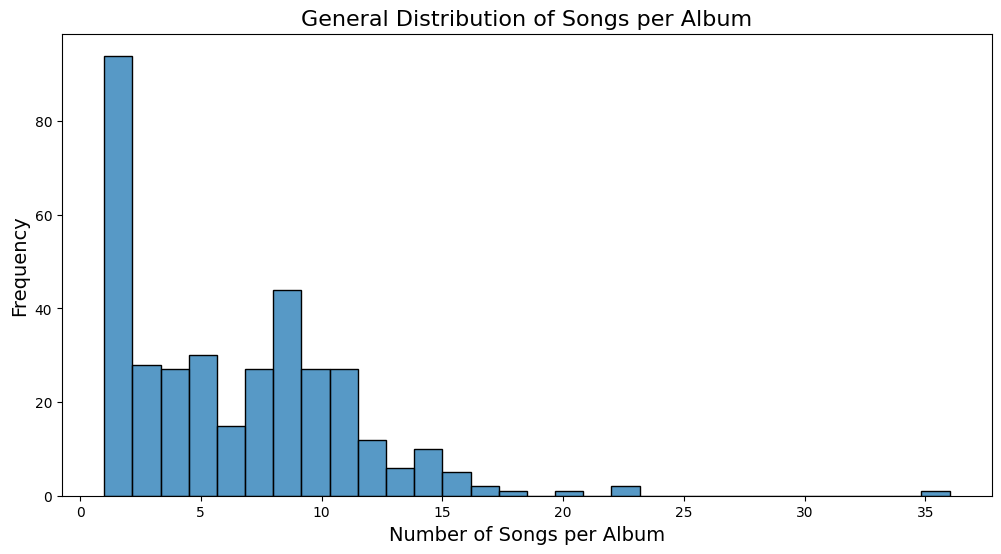

In [69]:
# plot number of songs per album
import matplotlib.pyplot as plt
import seaborn as sns

def plot_general_distribution(merged_df):
    # Count the number of songs per album
    album_counts = merged_df['merged_album'].value_counts()

    # Set the figure size
    plt.figure(figsize=(12, 6))

    # Create a histogram to show the general distribution
    sns.histplot(album_counts, bins=30, kde=False)

    # Set the title and labels
    plt.title('General Distribution of Songs per Album', fontsize=16)
    plt.xlabel('Number of Songs per Album', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Show the plot
    plt.show()

plot_general_distribution(merged_df)


Finally, let's save the album dataframe with merged album data for each song:

In [ ]:
merged_df

,title,artist,albums,albums_filtered,lastfm_album,spotify_album,merged_album,normalized_album
0,Без бою,Океан Ельзи,"['1221', 'Gloria']","['1221', 'Gloria']",Gloria,Gloria,Gloria,ґлоріа
1,Обійми,Океан Ельзи,"['Земля', 'Обійми']",['Земля'],Земля,Земля,Земля,земля
2,Не питай,Океан Ельзи,"['1221', 'Gloria']","['1221', 'Gloria']",Gloria,Gloria,Gloria,ґлоріа
3,Коли тебе нема,Океан Ельзи,"['Янанебібув', 'The Best Of']",['Янанебібув'],Янанебібув,Янанебібув,Янанебібув,янанебібув
4,911,Океан Ельзи,"['Модель', 'The Best Of']",['Модель'],Модель,Модель,Модель,модель
...,...,...,...,...,...,...,...,...
3161,MLNL,Антитіла,['MLNL'],['MLNL'],MLNL,MLNL,MLNL,млнл
3162,Заходь до мене в гості,Антитіла,[],[],None,NaN,NaN,None
3163,Топити за своє,Антитіла,['MLNL'],['MLNL'],MLNL,MLNL,MLNL,млнл
3164,Шанхай,Антитіла,[],[],None,NaN,NaN,None


In [ ]:
merged_df[['title', 'artist', 'merged_album']].to_csv(os.path.join("data", "merged_albums_songs_v1.csv"), index=False)

In [68]:
# TODO: consider merging with the lastfm_df "merged_songs_v1.csv" file